In [3]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import graph_tool.all as gt



src_dir = os.path.abspath(os.path.join(os.pardir,os.pardir, 'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support
import network.shift_graph_maker as sgm

In [2]:
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd

0.3455920299442113

In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [11]:
with open('/home/projects/movie-network/data/raw_data/movies.json') as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)

In [12]:
role = 'producing'
role_key = role + "_gender_percentage"
all_movies = support.get_movies_df(role_key)
print('Got all_movies')


Loaded IMDb movies producing_gender_percentage
Got all_movies


In [13]:
#get 90s movies with only producer, id, title, year...
movie_90s = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
movie_producer_df = movie_90s[['_id', 'producers', 'producing_gender_percentage', 'title', 'year', 'genres']]

In [14]:
movie_producer_df = movie_producer_df.sort_values('year')

In [15]:
movie_producer_df.head()

,_id,producers,producing_gender_percentage,title,year,genres
22884,tt0099622,"[[nm0000339, producer], [nm0515891, producer],...",33.333333,Full Fathom Five,1990,"[Action, Adventure]"
22502,tt0100822,"[[nm0135847, executive producer], [nm0275836, ...",0.000000,Tune in Tomorrow...,1990,"[Comedy, Romance]"
10973,tt0100935,"[[nm0326512, producer], [nm0474138, executive ...",0.000000,Wild at Heart,1990,"[Comedy, Crime, Drama, Thriller]"
22559,tt0099819,"[[nm0342045, executive producer], [nm0270288, ...",20.000000,I Love You to Death,1990,"[Comedy, Crime]"
24509,tt0099796,"[[nm0321860, line producer], [nm0711910, produ...",50.000000,Horseplayer,1990,"[Drama, Thriller]"


## Community detecton using graph_tool

In [16]:
movie_producer_df = movie_producer_df.set_index('_id')
movie_producer_dict = movie_producer_df.to_dict(orient='index')

### Make graph

## Stochastic block model

In [18]:
clabel = g.vp['kind']

## remove nodes with one edge

In [22]:
g = sgm.make_graph(movie_producer_dict)

In [23]:
one_degree_nodes = []
for v in g.vertices():
    edge_num = len(g.get_out_edges(v))
    if edge_num == 1:
        one_degree_nodes.append(v)

In [24]:
for v in reversed(sorted(one_degree_nodes)):
    g.remove_vertex(v)

In [31]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)
state.entropy()

48051.132769211086

In [32]:
g.num_vertices()

3769

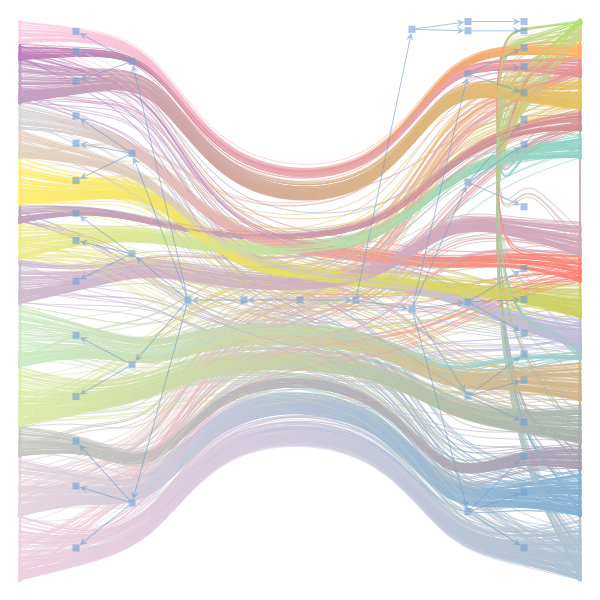

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f0542f7ec50, at 0x7f05439a2630>,
 <Graph object, directed, with 3818 vertices and 3817 edges at 0x7f054372dd68>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f054372dd68, at 0x7f0542f2d278>)

In [33]:
gt.draw_hierarchy(state,layout='bipartite',\
              output=None,\
              subsample_edges=1500,\
              hshortcuts=1, hide=0,\
              beta=0.5
              )

In [34]:
print(state.entropy())
state

48051.132769211086


<NestedBlockState object, with base <BlockState object with 31 blocks (31 nonempty), degree-corrected, for graph <Graph object, undirected, with 3769 vertices and 6751 edges at 0x7f0542f7ec50>, at 0x7f05445e7b38>, and 5 levels of sizes [(3769, 31), (31, 12), (12, 3), (3, 2), (2, 1)] at 0x7f054441f550>

In [37]:
blocks = state.get_bs()[0]


In [38]:
i = 0
for v in g.vertices():
    print (g.vp['name'][v])
    print(blocks[v])
    i += 1
    if i == 100:
        break

tt0099622


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Genres - Community relations

In [ ]:
genre_dict = list(movie_producer_df[['genres']].to_dict().values())[0]

### Movies with multiple genres

In [ ]:
movie_producer_df

In [ ]:
movie_genre_df = movi